# Viewer with dask delay

This notebook is for segmenting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [1]:
import napari
import cellpose
from octopuslite import utils, tile

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = utils.read_harmony_metadata(metadata_fn)

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml'
utils.read_harmony_metadata(metadata_path, assay_layout=True)

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Define row and column of choice

In [4]:
row = '3'
column = '7'

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [5]:
images = tile.compile_mosaic(image_dir, metadata, row, column, )
images

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

,Array,Chunk
Bytes,30.66 GiB,46.51 MiB
Shape,"(75, 2, 3, 6048, 6048)","(1, 2, 3, 2016, 2016)"
Count,13500 Tasks,675 Chunks
Type,uint16,numpy.ndarray


In [6]:
images = tile.compile_mosaic(image_dir, metadata, row, column, set_plane= 2, set_channel=2, set_time=73)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
images

dask.array<reshape, shape=(1, 1, 1, 6048, 6048), dtype=uint16, chunksize=(1, 1, 1, 2016, 2016), chunktype=numpy.ndarray>

# Only compile subset of whole image

# Segment 
Let us start simple, only segmenting the lowest Z plane where the largest regions of cells are and only ch1 (GFP) where the GFP signal is.

In [ ]:
!nvcc --version
!nvidia-smi

from cellpose import core, utils, io, models, metrics

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

model = models.Cellpose(gpu=True, model_type='cyto')

def segment(img):
    masks, flows, styles, diams = model.eval(img, diameter=200, channels=[0,0],
                                             flow_threshold=None, cellprob_threshold=0)
    return masks

In [10]:
import os
import pandas as pd
import numpy as np
from typing import Tuple, List, Dict, Union, Optional, Callable
ArrayLike = Union[
    np.ndarray, "dask.array.Array"
]
import dask
import dask.array as da
from functools import partial
from pathlib import Path
FilePath = Union[Path, str]
from tqdm.auto import tqdm

In [12]:
chunk_fraction = 9
load_transform_image = partial(load_image, transforms=input_transforms)

In [11]:
def load_image(
    file: FilePath, transforms: List[Callable[[ArrayLike], ArrayLike]] = None
) -> np.ndarray:
    img = imread(file)
    # if img.ndim == 2:
    #    img = np.expand_dims(img, axis=0)
    if transforms is not None:
        for t in transforms:
            img = t(img)
    return img

In [8]:
input_transforms = None

In [13]:
image_directory = image_dir

In [14]:
set_time = 0
set_channel = 1
set_plane = 1

In [16]:
channel_IDs = (metadata['ChannelID'].unique() 
               if set_channel == None else [set_channel])
plane_IDs = (metadata['PlaneID'].unique() 
             if set_plane == None else [set_plane])
timepoint_IDs = (metadata['TimepointID'].unique() 
             if set_time == None else [set_time])

In [24]:
channel_IDs = metadata['ChannelID'].unique() 
              
plane_IDs = metadata['PlaneID'].unique() 
             
timepoint_IDs = metadata['TimepointID'].unique() 
             

trying to both make it so that only a single slice can be tiled and also to do in a dask delayed manner

In [17]:
from tqdm.auto import tqdm

In [61]:
### stitch the images together over all defined axis
images = [tile.stitch(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False)[0]
                    for plane in tqdm(plane_IDs, leave = False)
                for channel in tqdm(channel_IDs, leave = False)
                for time in tqdm(timepoint_IDs, leave = False)]
### stack them together
images = da.stack(images, axis = 0)
# ### reshape them according to TCZXY
images = images.reshape((len(timepoint_IDs), 
                         len(channel_IDs), 
                         len(plane_IDs), 
                         images.shape[-2], images.shape[-1]))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]


KeyboardInterrupt



# now try dask delayed

In [19]:
import dask.array as da
import dask

In [21]:
col = column

In [29]:
import numpy as np

In [32]:
time, plane, channel = 1, 1, 1

In [34]:
dask.delayed(tile.stitch)(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False).compute()

(dask.array<fuse_func, shape=(6048, 6048), dtype=uint16, chunksize=(2016, 2016), chunktype=numpy.ndarray>,
  <shapely.geometry.polygon.Polygon at 0x7f5c4611bdc0>])

In [30]:
### stitch the images together over all defined axis
images = [da.from_delayed(
          dask.delayed(tile.stitch)(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False),
                    shape = (6048, 6048), 
                    dtype = np.uint16
                    )[0]
                    for plane in tqdm(plane_IDs, leave = False)
                    for channel in tqdm(channel_IDs, leave = False)
                    for time in tqdm(timepoint_IDs, leave = False)]
### stack them together
images = da.stack(images, axis = 0)
### reshape them according to TCZXY
images = images.reshape((len(timepoint_IDs), 
                         len(channel_IDs), 
                         len(plane_IDs), 
                         images.shape[-2], images.shape[-1]))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

ValueError: total size of new array must be unchanged

In [121]:
### stitch the images together over all defined axis 
### but do so in using dask delayed
images = [dask.delayed(tile.stitch)(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False)[0]
                    
                    for plane in tqdm(plane_IDs, leave = False)
                    for channel in tqdm(channel_IDs, leave = False)
                    for time in tqdm(timepoint_IDs, leave = False)]
### create a series of dask arrays out of the delayed funcs
images = [da.from_delayed(frame,
                shape = (6048, 6048), 
                dtype = np.uint16)
                for frame in images]
### rechunk so they are more managable 
images = [frame.rechunk(2016,2016) for frame in images]
### stack them together
images = da.stack(images, axis = 0)
# ### reshape them according to TCZXY
images = images.reshape((len(timepoint_IDs), 
                         len(channel_IDs), 
                         len(plane_IDs), 
                         images.shape[-2], images.shape[-1]))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

In [119]:
from skimage.io import imshow, imread

In [118]:
images[0,0,0].compute()

dask.array<getitem, shape=(6048, 6048), dtype=uint16, chunksize=(2016, 2016), chunktype=numpy.ndarray>

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


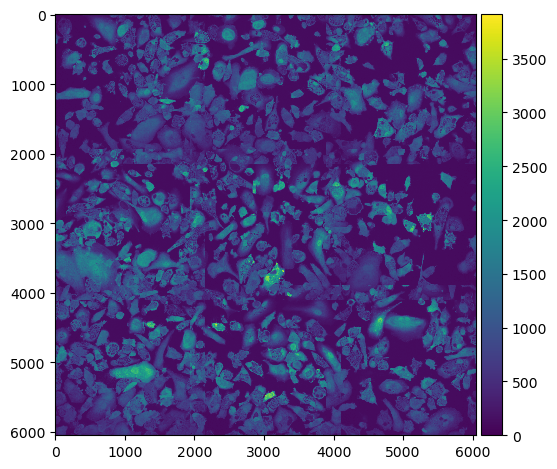

In [122]:
imshow(images[0,0,0].compute())

# Note: think some of the dimensionality may have gotten muddled, with channels appearing swapped at times...


In [123]:
viewer = napari.Viewer()

viewer.add_image(images, 
                 channel_axis=1,
                 name=["macrophage", "mtb"],
                 colormap=["green", "magenta"],
                 contrast_limits=[[100, 2000], [100, 500]]
                 )
# viewer.add_labels(mask_images, 
#                  )

Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


[<Image layer 'macrophage' at 0x7f5c5e90d670>,
 <Image layer 'mtb' at 0x7f5c363f2ca0>]

In [58]:
images = da.stack([tile.stitch(load_transform_image,
                                    metadata,
                                    image_directory,
                                    time,
                                    plane,
                                    channel,
                                    str(row),
                                    str(col),
                                    chunk_fraction,
                                    mask = False)[0]
                    for plane in plane_IDs
                    for channel in channel_IDs
                    for time in timepoint_IDs], 
                    axis = 0)

images = images.reshape((len(timepoint_IDs), 
                         len(channel_IDs), 
                         len(plane_IDs), 
                         images.shape[-2], images.shape[-1]))